In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from skimage.feature import local_binary_pattern

In [2]:
# Function to convert RGB image to HSI
def rgb_to_hsi(image):
    hsi_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    return hsi_image

# Function for GrabCut segmentation
def segment_leaf(image):
    # Convert image to HSI
    hsi_image = rgb_to_hsi(image)

    # Extract hue component
    hue = hsi_image[:, :, 0]

    # Thresholding on hue channel to separate leaf from background
    _, binary_mask = cv2.threshold(hue, 30, 255, cv2.THRESH_BINARY)

    # Perform morphological operations to refine the mask
    kernel = np.ones((5, 5), np.uint8)
    opening = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    _, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0

    # Apply watershed algorithm
    markers = cv2.watershed(image, markers)
    image[markers == -1] = [255, 0, 0]  # Mark watershed boundary on original image

    # Convert markers to binary mask
    mask = np.zeros_like(binary_mask)
    mask[markers > 1] = 255  # Mark region other than background

    # Apply the mask to original image
    segmented_image = cv2.bitwise_and(image, image, mask=mask)

    return segmented_image

# Function for LBP feature extraction
def extract_features(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Compute Local Binary Pattern
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')

    # Calculate histogram of LBP
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

    return hist

# Function to load images from folders
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [3]:
# Load healthy and infected leaf images
healthy_folder = r"C:\Users\dubey\OneDrive\Desktop\ML Classroom Project\Leaf_Train\Healthy"
infected_folder = r"C:\Users\dubey\OneDrive\Desktop\ML Classroom Project\Leaf_Train\Infected"

healthy_images = load_images_from_folder(healthy_folder)
infected_images = load_images_from_folder(infected_folder)

# Segment and extract features for healthy images
healthy_features = []
for img in healthy_images:
    segmented_img = segment_leaf(img)
    features = extract_features(segmented_img)
    healthy_features.append(features)

# Segment and extract features for infected images
infected_features = []
for img in infected_images:
    segmented_img = segment_leaf(img)
    features = extract_features(segmented_img)
    infected_features.append(features)

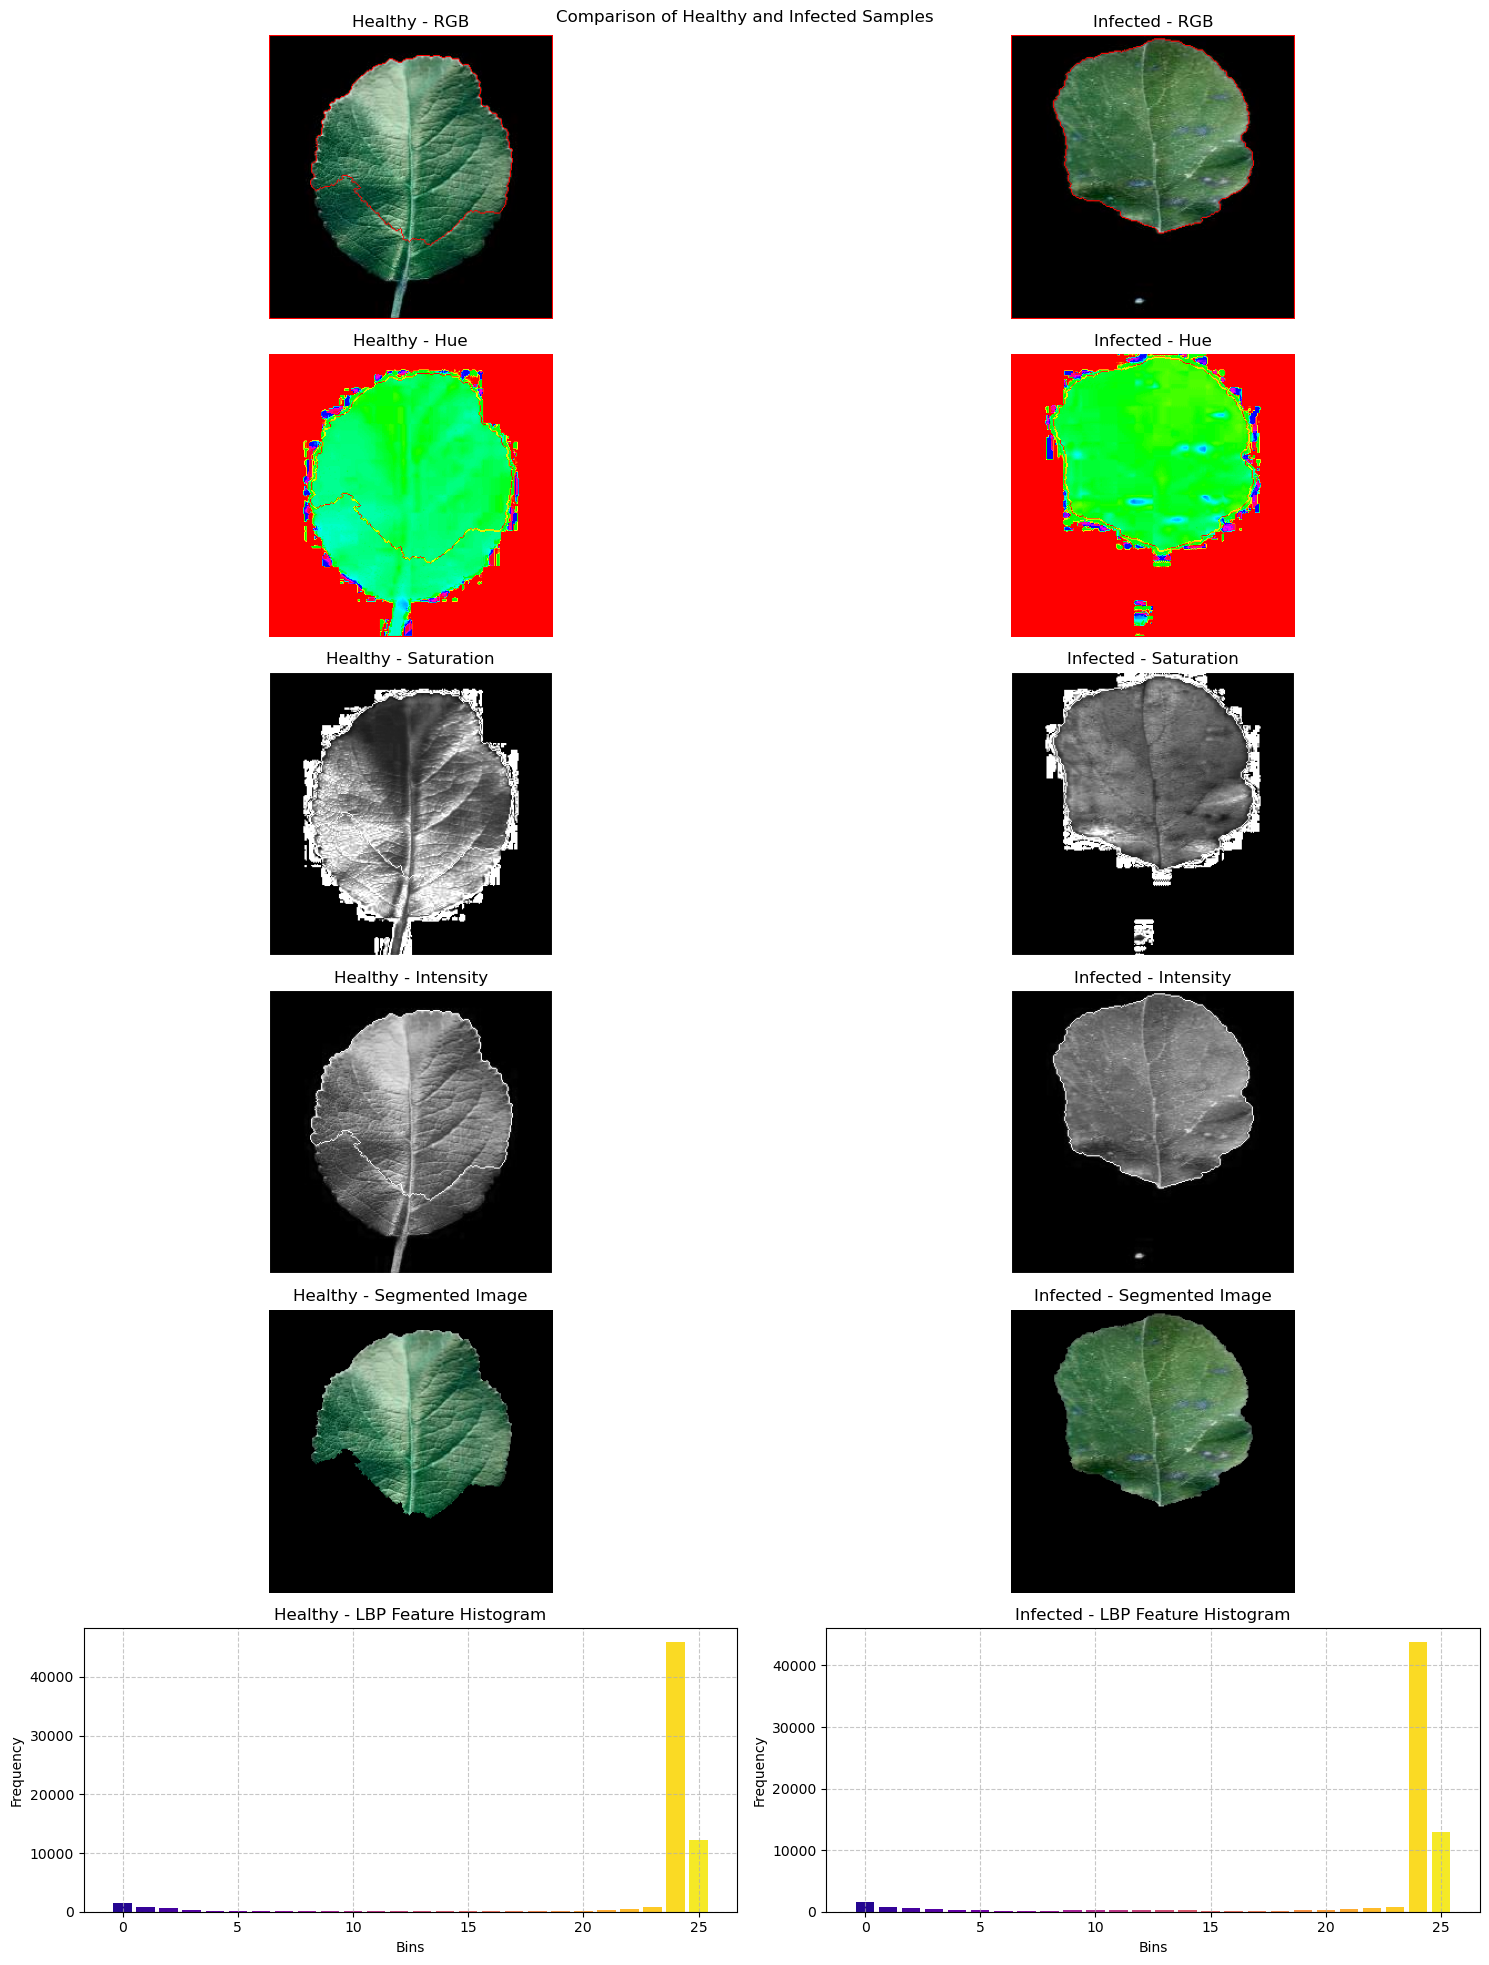

In [4]:
# Function to visualize HSI conversion and extracted features for a sample image
def visualize_samples(healthy_image, infected_image):
    fig, axes = plt.subplots(6, 2, figsize=(15, 20))

    # Visualize healthy image
    axes[0, 0].imshow(healthy_image)
    axes[0, 0].set_title('Healthy - RGB')
    axes[0, 0].axis('off')

    axes[1, 0].imshow(rgb_to_hsi(healthy_image)[:, :, 0], cmap='hsv')
    axes[1, 0].set_title('Healthy - Hue')
    axes[1, 0].axis('off')

    axes[2, 0].imshow(rgb_to_hsi(healthy_image)[:, :, 1], cmap='gray')
    axes[2, 0].set_title('Healthy - Saturation')
    axes[2, 0].axis('off')

    axes[3, 0].imshow(rgb_to_hsi(healthy_image)[:, :, 2], cmap='gray')
    axes[3, 0].set_title('Healthy - Intensity')
    axes[3, 0].axis('off')

    segmented_img_healthy = segment_leaf(healthy_image)
    features_healthy = extract_features(segmented_img_healthy)

    axes[4, 0].imshow(segmented_img_healthy)
    axes[4, 0].set_title('Healthy - Segmented Image')
    axes[4, 0].axis('off')

    num_bins_healthy = len(features_healthy)
    colors_healthy = sns.color_palette("plasma", num_bins_healthy)

    axes[5, 0].bar(range(num_bins_healthy), features_healthy, color=colors_healthy)
    axes[5, 0].set_title('Healthy - LBP Feature Histogram')
    axes[5, 0].set_xlabel('Bins')
    axes[5, 0].set_ylabel('Frequency')
    axes[5, 0].grid(True, linestyle='--', alpha=0.7)

    # Visualize infected image
    axes[0, 1].imshow(infected_image)
    axes[0, 1].set_title('Infected - RGB')
    axes[0, 1].axis('off')

    axes[1, 1].imshow(rgb_to_hsi(infected_image)[:, :, 0], cmap='hsv')
    axes[1, 1].set_title('Infected - Hue')
    axes[1, 1].axis('off')

    axes[2, 1].imshow(rgb_to_hsi(infected_image)[:, :, 1], cmap='gray')
    axes[2, 1].set_title('Infected - Saturation')
    axes[2, 1].axis('off')

    axes[3, 1].imshow(rgb_to_hsi(infected_image)[:, :, 2], cmap='gray')
    axes[3, 1].set_title('Infected - Intensity')
    axes[3, 1].axis('off')

    segmented_img_infected = segment_leaf(infected_image)
    features_infected = extract_features(segmented_img_infected)

    axes[4, 1].imshow(segmented_img_infected)
    axes[4, 1].set_title('Infected - Segmented Image')
    axes[4, 1].axis('off')

    num_bins_infected = len(features_infected)
    colors_infected = sns.color_palette("plasma", num_bins_infected)

    axes[5, 1].bar(range(num_bins_infected), features_infected, color=colors_infected)
    axes[5, 1].set_title('Infected - LBP Feature Histogram')
    axes[5, 1].set_xlabel('Bins')
    axes[5, 1].set_ylabel('Frequency')
    axes[5, 1].grid(True, linestyle='--', alpha=0.7)

    plt.suptitle("Comparison of Healthy and Infected Samples")
    plt.tight_layout()
    plt.show()

# Visualize a sample image from the healthy dataset and the infected dataset
visualize_samples(healthy_images[0], infected_images[0])

In [5]:
# Create dataframes for healthy and infected features
healthy_df = pd.DataFrame(healthy_features)
infected_df = pd.DataFrame(infected_features)

# Label healthy as 0 and infected as 1
healthy_df['label'] = 0
infected_df['label'] = 1

# Combine dataframes
df = pd.concat([healthy_df, infected_df], ignore_index=True)

In [6]:
df

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,label
0,1465,884,584,319,187,129,107,114,134,145,...,118,121,151,197,279,502,789,45950,12256,0
1,2031,1089,751,465,325,224,190,166,202,201,...,193,209,217,292,446,712,1011,38456,16623,0
2,983,641,267,98,61,45,41,29,21,26,...,35,43,44,39,70,183,528,54640,7454,0
3,1407,872,469,183,112,87,74,84,97,119,...,75,86,81,118,192,362,789,47897,11422,0
4,1709,1017,494,221,128,96,85,76,83,112,...,84,81,98,157,185,439,883,45082,13606,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2312,1253,870,580,352,300,240,215,247,240,...,255,227,248,302,477,734,1234,34063,19083,1
596,735,410,256,155,101,80,74,82,58,72,...,57,70,56,81,87,179,348,56249,5842,1
597,2496,946,907,745,558,433,340,303,292,334,...,304,337,434,562,645,883,914,35296,16047,1
598,1130,545,456,306,212,226,196,212,246,253,...,187,216,216,224,260,367,475,48292,9079,1


In [7]:
# Model fitting
X = df.drop('label', axis=1)
y = df['label']

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# SVM model
svm_model = SVC()
svm_model.probability = True
svm_model.fit(X_train, y_train)

SVC(probability=True)

In [8]:
# Model evaluation
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8083333333333333
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81        62
           1       0.80      0.81      0.80        58

    accuracy                           0.81       120
   macro avg       0.81      0.81      0.81       120
weighted avg       0.81      0.81      0.81       120



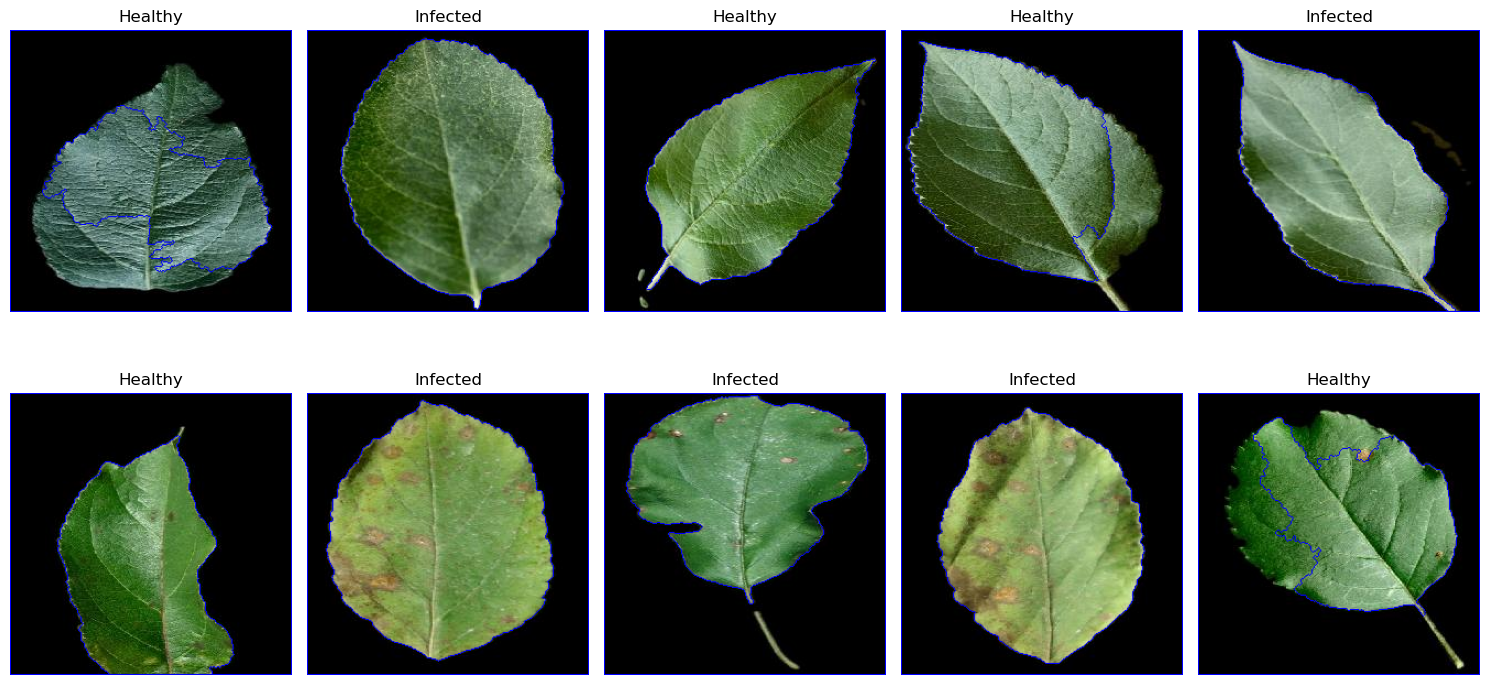

In [9]:
# Function to display original images with labels in rows
def show_original_images_with_labels_in_rows(images, labels, num_rows=2):
    num_images_per_row = math.ceil(len(images) / num_rows)
    fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(15, 8))
    for i in range(num_rows):
        for j in range(num_images_per_row):
            index = i * num_images_per_row + j
            if index < len(images):
                axes[i, j].imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
                axes[i, j].set_title(labels[index])
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

# Load images from the test folder
test_folder = r"C:\Users\dubey\OneDrive\Desktop\ML Classroom Project\Leaf_Test"
test_images = load_images_from_folder(test_folder)

# Scale the test images using the same scaler used during training
scaled_test_images = []

for img in test_images:
    # Segment the leaf region
    segmented_img = segment_leaf(img)
    
    # Extract features from segmented image
    features = extract_features(segmented_img)
    
    # Scale the features
    scaled_features = scaler.transform([features])  # Assuming 'scaler' is your StandardScaler object
    
    # Make predictions
    prediction = svm_model.predict(scaled_features)[0]
    scaled_test_images.append("Infected" if prediction == 1 else "Healthy")  # Mapping 0 and 1 to Healthy and Infected

# Display original test images with predicted labels in two rows
show_original_images_with_labels_in_rows(test_images, scaled_test_images, num_rows=2)

In [10]:
# Defining parameter ranges for different kernels
param_grid = {
    'C': [0.0001, 0.001, 0.1, 1, 10, 100, 1000], 
    'gamma': [0.0001, 0.001, 0.1, 1, 10, 100, 1000], 
    'kernel': ['linear', 'rbf', 'sigmoid']
} 

# Create GridSearchCV object
grid = GridSearchCV(estimator=svm_model, param_grid=param_grid, refit=True, verbose=3) 

# Fit the model for grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 147 candidates, totalling 735 fits
[CV 1/5] END C=0.0001, gamma=0.0001, kernel=linear;, score=0.688 total time=   0.0s
[CV 2/5] END C=0.0001, gamma=0.0001, kernel=linear;, score=0.667 total time=   0.0s
[CV 3/5] END C=0.0001, gamma=0.0001, kernel=linear;, score=0.802 total time=   0.0s
[CV 4/5] END C=0.0001, gamma=0.0001, kernel=linear;, score=0.667 total time=   0.0s
[CV 5/5] END C=0.0001, gamma=0.0001, kernel=linear;, score=0.646 total time=   0.0s
[CV 1/5] END C=0.0001, gamma=0.0001, kernel=rbf;, score=0.500 total time=   0.0s
[CV 2/5] END C=0.0001, gamma=0.0001, kernel=rbf;, score=0.500 total time=   0.0s
[CV 3/5] END C=0.0001, gamma=0.0001, kernel=rbf;, score=0.500 total time=   0.0s
[CV 4/5] END C=0.0001, gamma=0.0001, kernel=rbf;, score=0.510 total time=   0.0s
[CV 5/5] END C=0.0001, gamma=0.0001, kernel=rbf;, score=0.510 total time=   0.0s
[CV 1/5] END C=0.0001, gamma=0.0001, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 2/5] END C=0.0001, gamm

[CV 4/5] END C=0.0001, gamma=1000, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 5/5] END C=0.0001, gamma=1000, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 1/5] END C=0.001, gamma=0.0001, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/5] END C=0.001, gamma=0.0001, kernel=linear;, score=0.781 total time=   0.0s
[CV 3/5] END C=0.001, gamma=0.0001, kernel=linear;, score=0.833 total time=   0.0s
[CV 4/5] END C=0.001, gamma=0.0001, kernel=linear;, score=0.760 total time=   0.0s
[CV 5/5] END C=0.001, gamma=0.0001, kernel=linear;, score=0.771 total time=   0.0s
[CV 1/5] END .C=0.001, gamma=0.0001, kernel=rbf;, score=0.500 total time=   0.0s
[CV 2/5] END .C=0.001, gamma=0.0001, kernel=rbf;, score=0.500 total time=   0.0s
[CV 3/5] END .C=0.001, gamma=0.0001, kernel=rbf;, score=0.500 total time=   0.0s
[CV 4/5] END .C=0.001, gamma=0.0001, kernel=rbf;, score=0.510 total time=   0.0s
[CV 5/5] END .C=0.001, gamma=0.0001, kernel=rbf;, score=0.510 total time=   0.0s
[CV 1/5] END C

[CV 2/5] END C=0.001, gamma=1000, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/5] END C=0.001, gamma=1000, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 4/5] END C=0.001, gamma=1000, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 5/5] END C=0.001, gamma=1000, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 1/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.823 total time=   0.0s
[CV 2/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.896 total time=   0.0s
[CV 3/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.885 total time=   0.0s
[CV 4/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.812 total time=   0.0s
[CV 5/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.833 total time=   0.0s
[CV 1/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.500 total time=   0.0s
[CV 2/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.500 total time=   0.0s
[CV 3/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.500 total time=   0.0s
[CV 4/5] END ...C=0.1, g

[CV 5/5] END .....C=0.1, gamma=1000, kernel=rbf;, score=0.510 total time=   0.0s
[CV 1/5] END .C=0.1, gamma=1000, kernel=sigmoid;, score=0.656 total time=   0.0s
[CV 2/5] END .C=0.1, gamma=1000, kernel=sigmoid;, score=0.615 total time=   0.0s
[CV 3/5] END .C=0.1, gamma=1000, kernel=sigmoid;, score=0.729 total time=   0.0s
[CV 4/5] END .C=0.1, gamma=1000, kernel=sigmoid;, score=0.656 total time=   0.0s
[CV 5/5] END .C=0.1, gamma=1000, kernel=sigmoid;, score=0.625 total time=   0.0s
[CV 1/5] END ..C=1, gamma=0.0001, kernel=linear;, score=0.854 total time=   0.0s
[CV 2/5] END ..C=1, gamma=0.0001, kernel=linear;, score=0.875 total time=   0.0s
[CV 3/5] END ..C=1, gamma=0.0001, kernel=linear;, score=0.875 total time=   0.0s
[CV 4/5] END ..C=1, gamma=0.0001, kernel=linear;, score=0.812 total time=   0.0s
[CV 5/5] END ..C=1, gamma=0.0001, kernel=linear;, score=0.833 total time=   0.0s
[CV 1/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.740 total time=   0.0s
[CV 2/5] END .....C=1, gamma

[CV 3/5] END .......C=1, gamma=1000, kernel=rbf;, score=0.500 total time=   0.0s
[CV 4/5] END .......C=1, gamma=1000, kernel=rbf;, score=0.510 total time=   0.0s
[CV 5/5] END .......C=1, gamma=1000, kernel=rbf;, score=0.510 total time=   0.0s
[CV 1/5] END ...C=1, gamma=1000, kernel=sigmoid;, score=0.552 total time=   0.0s
[CV 2/5] END ...C=1, gamma=1000, kernel=sigmoid;, score=0.542 total time=   0.0s
[CV 3/5] END ...C=1, gamma=1000, kernel=sigmoid;, score=0.677 total time=   0.0s
[CV 4/5] END ...C=1, gamma=1000, kernel=sigmoid;, score=0.583 total time=   0.0s
[CV 5/5] END ...C=1, gamma=1000, kernel=sigmoid;, score=0.562 total time=   0.0s
[CV 1/5] END .C=10, gamma=0.0001, kernel=linear;, score=0.854 total time=   0.2s
[CV 2/5] END .C=10, gamma=0.0001, kernel=linear;, score=0.844 total time=   0.2s
[CV 3/5] END .C=10, gamma=0.0001, kernel=linear;, score=0.875 total time=   0.2s
[CV 4/5] END .C=10, gamma=0.0001, kernel=linear;, score=0.802 total time=   0.2s
[CV 5/5] END .C=10, gamma=0.

[CV 5/5] END ...C=10, gamma=1000, kernel=linear;, score=0.833 total time=   0.2s
[CV 1/5] END ......C=10, gamma=1000, kernel=rbf;, score=0.500 total time=   0.0s
[CV 2/5] END ......C=10, gamma=1000, kernel=rbf;, score=0.500 total time=   0.0s
[CV 3/5] END ......C=10, gamma=1000, kernel=rbf;, score=0.500 total time=   0.0s
[CV 4/5] END ......C=10, gamma=1000, kernel=rbf;, score=0.510 total time=   0.0s
[CV 5/5] END ......C=10, gamma=1000, kernel=rbf;, score=0.510 total time=   0.0s
[CV 1/5] END ..C=10, gamma=1000, kernel=sigmoid;, score=0.552 total time=   0.0s
[CV 2/5] END ..C=10, gamma=1000, kernel=sigmoid;, score=0.531 total time=   0.0s
[CV 3/5] END ..C=10, gamma=1000, kernel=sigmoid;, score=0.656 total time=   0.0s
[CV 4/5] END ..C=10, gamma=1000, kernel=sigmoid;, score=0.583 total time=   0.0s
[CV 5/5] END ..C=10, gamma=1000, kernel=sigmoid;, score=0.562 total time=   0.0s
[CV 1/5] END C=100, gamma=0.0001, kernel=linear;, score=0.854 total time=   3.8s
[CV 2/5] END C=100, gamma=0.

[CV 2/5] END ..C=100, gamma=1000, kernel=linear;, score=0.812 total time=   1.3s
[CV 3/5] END ..C=100, gamma=1000, kernel=linear;, score=0.854 total time=   0.9s
[CV 4/5] END ..C=100, gamma=1000, kernel=linear;, score=0.792 total time=   0.6s
[CV 5/5] END ..C=100, gamma=1000, kernel=linear;, score=0.833 total time=   1.3s
[CV 1/5] END .....C=100, gamma=1000, kernel=rbf;, score=0.500 total time=   0.0s
[CV 2/5] END .....C=100, gamma=1000, kernel=rbf;, score=0.500 total time=   0.0s
[CV 3/5] END .....C=100, gamma=1000, kernel=rbf;, score=0.500 total time=   0.0s
[CV 4/5] END .....C=100, gamma=1000, kernel=rbf;, score=0.510 total time=   0.0s
[CV 5/5] END .....C=100, gamma=1000, kernel=rbf;, score=0.510 total time=   0.0s
[CV 1/5] END .C=100, gamma=1000, kernel=sigmoid;, score=0.552 total time=   0.0s
[CV 2/5] END .C=100, gamma=1000, kernel=sigmoid;, score=0.531 total time=   0.0s
[CV 3/5] END .C=100, gamma=1000, kernel=sigmoid;, score=0.656 total time=   0.0s
[CV 4/5] END .C=100, gamma=1

[CV 1/5] END .C=1000, gamma=1000, kernel=linear;, score=0.854 total time=  12.8s
[CV 2/5] END .C=1000, gamma=1000, kernel=linear;, score=0.812 total time=  11.5s
[CV 3/5] END .C=1000, gamma=1000, kernel=linear;, score=0.854 total time=   8.8s
[CV 4/5] END .C=1000, gamma=1000, kernel=linear;, score=0.781 total time=   7.9s
[CV 5/5] END .C=1000, gamma=1000, kernel=linear;, score=0.833 total time=  10.2s
[CV 1/5] END ....C=1000, gamma=1000, kernel=rbf;, score=0.500 total time=   0.0s
[CV 2/5] END ....C=1000, gamma=1000, kernel=rbf;, score=0.500 total time=   0.0s
[CV 3/5] END ....C=1000, gamma=1000, kernel=rbf;, score=0.500 total time=   0.0s
[CV 4/5] END ....C=1000, gamma=1000, kernel=rbf;, score=0.510 total time=   0.0s
[CV 5/5] END ....C=1000, gamma=1000, kernel=rbf;, score=0.510 total time=   0.0s
[CV 1/5] END C=1000, gamma=1000, kernel=sigmoid;, score=0.552 total time=   0.0s
[CV 2/5] END C=1000, gamma=1000, kernel=sigmoid;, score=0.531 total time=   0.0s
[CV 3/5] END C=1000, gamma=1

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.0001, 0.001, 0.1, 1, 10, 100, 1000],
                         'gamma': [0.0001, 0.001, 0.1, 1, 10, 100, 1000],
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             verbose=3)

In [11]:
# print best parameter after tuning 
print(grid.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.0001, probability=True)


In [12]:
# Get the best hyperparameters and model
best_params = grid.best_params_
best_model = grid.best_estimator_

# Evaluate the best model
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Best SVM Accuracy: {accuracy_best:.2f}")
print(f"Best Hyperparameters: {best_params}")

Best SVM Accuracy: 0.84
Best Hyperparameters: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}


In [13]:
# Model evaluation
y_pred_best = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_best)
print("Classification Report:")
print(classification_report(y_test, y_pred_best))

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85        62
           1       0.83      0.84      0.84        58

    accuracy                           0.84       120
   macro avg       0.84      0.84      0.84       120
weighted avg       0.84      0.84      0.84       120



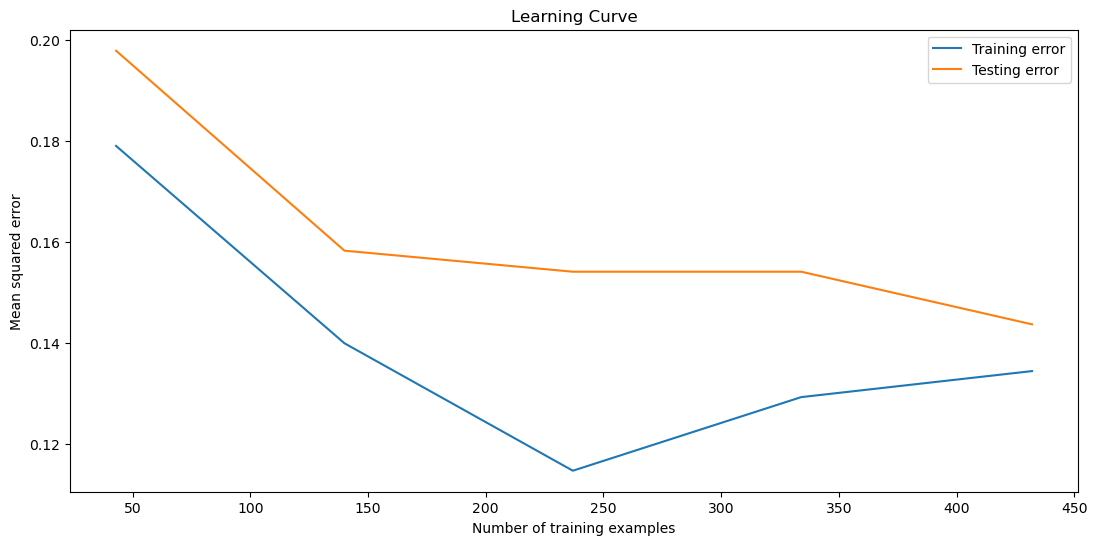

In [15]:
# Calculate learning curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Calculate mean training and testing error
train_errors = -train_scores.mean(axis=1)
test_errors = -test_scores.mean(axis=1)

# Plot learning curve
plt.figure(figsize=(13, 6))
plt.plot(train_sizes, train_errors, label='Training error')
plt.plot(train_sizes, test_errors, label='Testing error')
plt.xlabel('Number of training examples')
plt.ylabel('Mean squared error')
plt.title('Learning Curve')
plt.legend()
plt.grid(False)
plt.show()

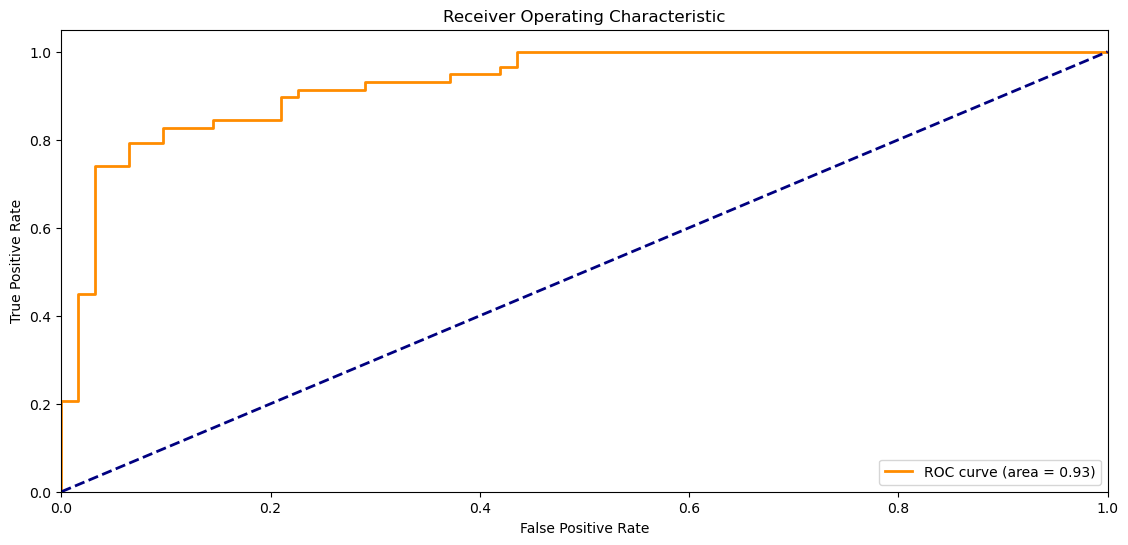

In [14]:
# ROC analysis
y_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(13.5, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
roc_auc

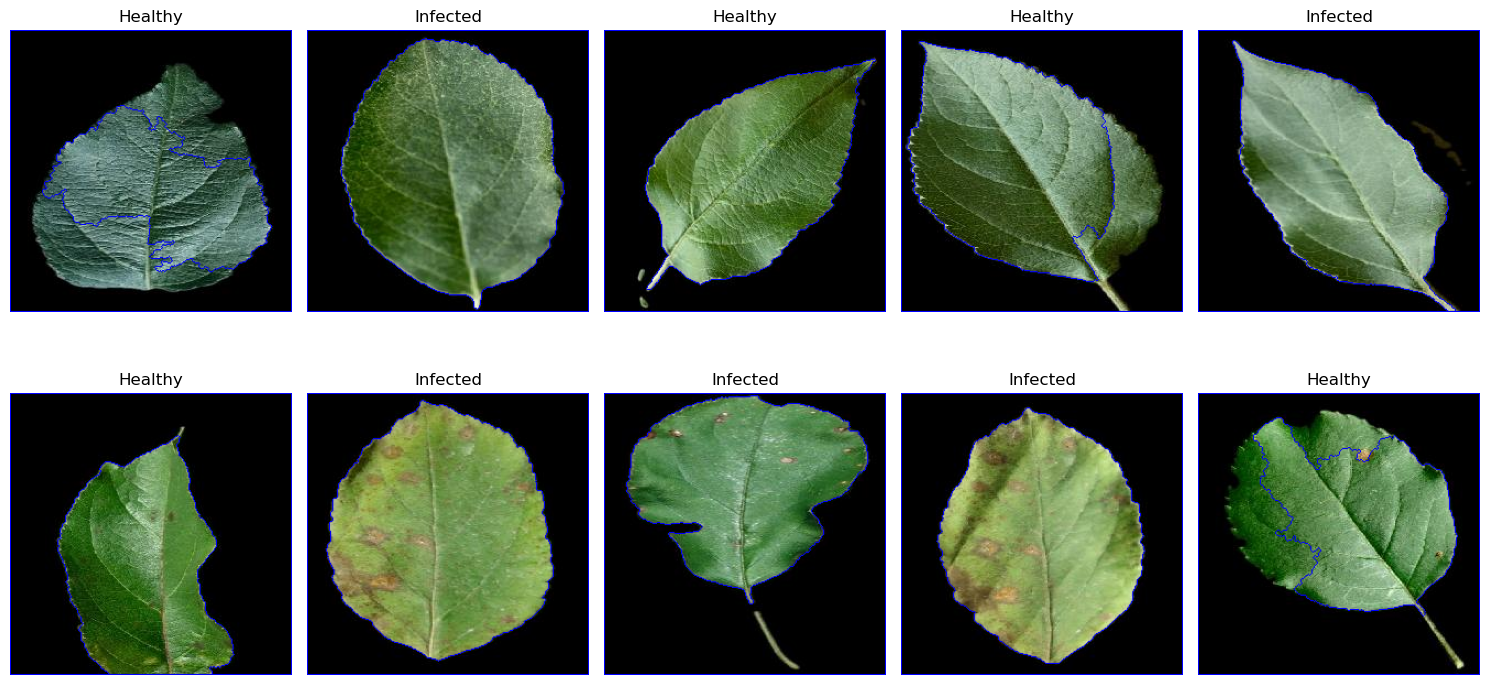

In [16]:
# Function to display original images with labels in rows
def show_original_images_with_labels_in_rows(images, labels, num_rows=2):
    num_images_per_row = math.ceil(len(images) / num_rows)
    fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(15, 8))
    for i in range(num_rows):
        for j in range(num_images_per_row):
            index = i * num_images_per_row + j
            if index < len(images):
                axes[i, j].imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
                axes[i, j].set_title(labels[index])
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

# Load images from the test folder
test_folder = r"C:\Users\dubey\OneDrive\Desktop\ML Classroom Project\Leaf_Test"
test_images = load_images_from_folder(test_folder)

# Scale the test images using the same scaler used during training
scaled_test_images = []

for img in test_images:
    # Segment the leaf region
    segmented_img = segment_leaf(img)
    
    # Extract features from segmented image
    features = extract_features(segmented_img)
    
    # Scale the features
    scaled_features = scaler.transform([features])  # Assuming 'scaler' is your StandardScaler object
    
    # Make predictions
    prediction = best_model.predict(scaled_features)[0]
    scaled_test_images.append("Infected" if prediction == 1 else "Healthy")  # Mapping 0 and 1 to Healthy and Infected

# Display original test images with predicted labels in two rows
show_original_images_with_labels_in_rows(test_images, scaled_test_images, num_rows=2)